### User settings

In [3]:
data_path = "./data/"

### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from thermopot import materials, calculations, reactions, potentials, potential 

### Read in data and build materials


In [22]:
# Ba-S system ground state energies
Ba_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/Ba_Im-3m/scan/aims.out")

# Zr calc
Zr_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/Zr_P63_mmc/scan/aims.out")

# S8 gas ground state energy
S8_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/S8/scan/aims.out",gas=True)

# BaZrS3 calc
BaZrS3_calc = calculations.AimsCalculation(data_path+"raw_aims_files/ternary/BaZrS3_Pnma/scan/aims.out")

In [23]:
Ba = materials.Solid("Ba",{"Ba": 1},data_path+"phonopy_output/Ba_Im-3m.dat",calculation=Ba_calc)

Zr = materials.Solid("Zr",{"Zr": 1},data_path+"phonopy_output/Zr_P63_mmc.dat",calculation=Zr_calc)

S8 = materials.IdealGas("S8",{'S':8},data_path+"nist_janaf/S8.dat",calculation=S8_calc,zpe_lit=0.335)  # from CCCBDB

BaZrS3 = materials.Solid("BaZrS3",{"Ba": 1,"Zr": 1,"S":3},data_path+"phonopy_output/BaZrS3_Pnma.dat",calculation=BaZrS3_calc)

S_g = materials.Sulfur_model(S8_calc.energy/8)  

### Define temperature and pressure range

The Sulfur model is only valid for 400-1500K and 10^0-10^7 Pascal.

In [24]:
T = np.linspace(400,1500,1000) # K
P = np.array( np.logspace(1,7,1000),ndmin=2).transpose() # Pa   valid region for sulfur mode

# S2 total energy using S8 as a reference

Instead of using a SCAN calculated total energy for the S2 allotrope, we reference it to the S8 allotrope using the energy difference reported in Adam's paper (https://doi.org/10.1039/C5SC03088A). This is a workaround for the fact that the difference in energy calculated at SCAN level of theory is too large.

In [25]:
eV_to_kJpermole = 96.485

delta_S2_S8_from_Jackson_model = 50 # in kJ per mole
delta_S2_S8_from_Jackson_model_eV = delta_S2_S8_from_Jackson_model*(1/eV_to_kJpermole) 
print(delta_S2_S8_from_Jackson_model_eV)
# this is energy difference between S2 and S8, per atom (in eV)

0.5182152666217547


In [26]:
S2_energy_referenced_to_S8 = ((S8_calc.energy/8) + delta_S2_S8_from_Jackson_model_eV)*2
# the factors of 8 and 2 are due to stoichiometry of systems

In [27]:
# create calculation object using this updated energy
S2_calc_referenced_to_S8 = calculations.Calculation(energy=S2_energy_referenced_to_S8,xc='scan',NAtoms=2)
# create material using updated calculation
S2_referenced_to_S8 = materials.IdealGas("S2",{'S':2},data_path+"nist_janaf/S2.dat",calculation=S2_calc_referenced_to_S8,zpe_lit=0.0893)   # from CCCBDB

## Figure 3a

Text(0.5, 0, 'Celsius')

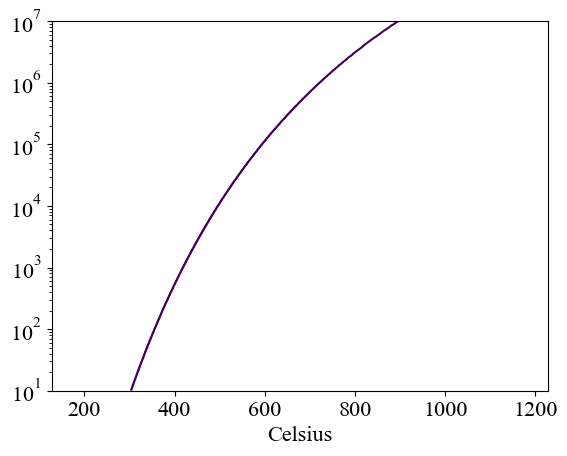

In [28]:
# compare formation energy of S2 and S8
S2_formation = reactions.Reaction({},{S2_referenced_to_S8:1},temperature=T,pressure=P)
S2_mu = S2_formation.Dmu(xc='scan',units="kJ")

S8_formation = reactions.Reaction({},{S8:1},temperature=T,pressure=P)
S8_mu = S8_formation.Dmu(xc='scan',units="kJ")

# plot line where chemical potential of S2 (which dominates at higher T / lower P) 
# is equal to chemical potential of S8 (which dominates at lower T / higher P)
plt.contour(T-273,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])
plt.yscale('log')
plt.xlabel("Celsius")

## Figure 3b

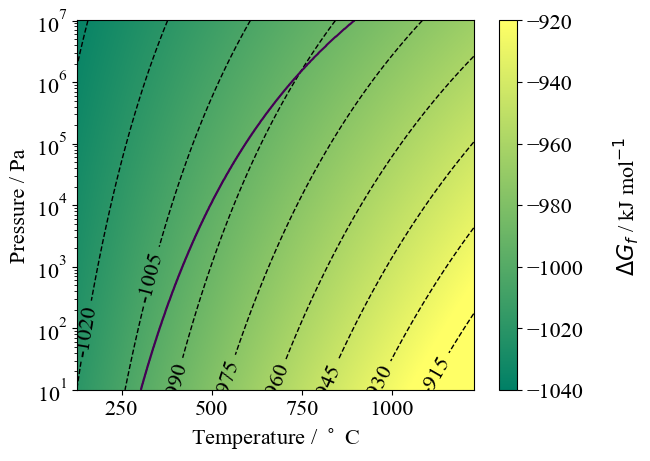

In [29]:
S8_reaction = reactions.Reaction({Ba:8,Zr:8,S8:3},{BaZrS3:8},temperature=T,pressure=P,fu=8)
GFE = S8_reaction.Dmu(units="kJ",xc='scan')
GFE.plot_TvsP(scale_range=[-1040, -920],T_units="C")
plt.contour(T-273,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])

## Figure 3b

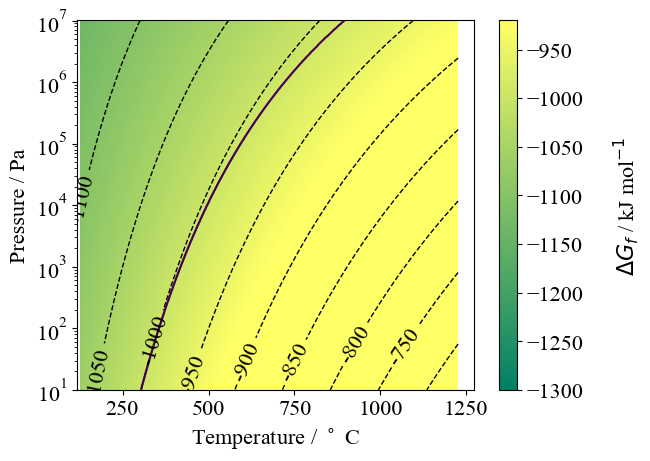

In [30]:
S2_reaction = reactions.Reaction({Ba:2,Zr:2,S2_referenced_to_S8:3},{BaZrS3:2},temperature=T,pressure=P,fu=2)
GFE = S2_reaction.Dmu(units="kJ",xc='scan')
GFE.plot_TvsP(scale_range=[-1300, -920],T_units="C")
plt.xlim(117,1273)
plt.contour(T-273,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])

## Figure 3d  - note no change to data (here for completeness in case needed).

<module 'matplotlib.pyplot' from '/Users/mynf8/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

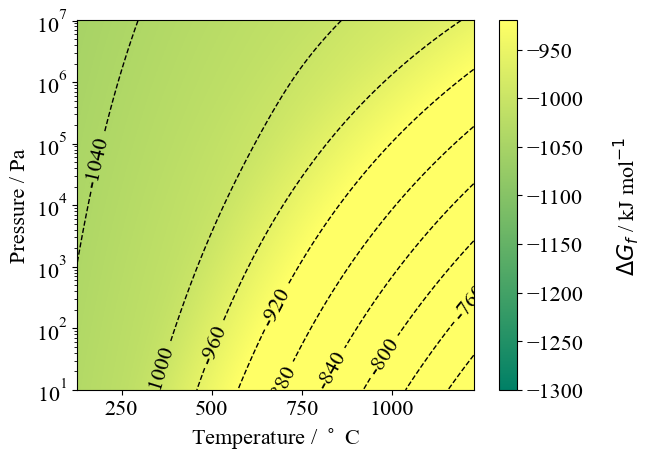

In [31]:
# Note this is no change to data!! So no need to re-plot- here for completeness
Sg_reaction = reactions.Reaction({Ba:1,Zr:1,S_g:3},{BaZrS3:1},temperature=T,pressure=P)
GFE = Sg_reaction.Dmu(units="kJ",xc='scan')
GFE.plot_TvsP(scale_range=[-1300, -920],T_units="C")

S23, S24, S25, S26